## Synchronised Chaos

### Implementing the transmitter and receiver

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.001
steps = 120000

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 3.0, 0.05)  # If the system synchronises, any initial values work

t = np.linspace(0, steps*dt, steps+1)   # time array

# Message signal sample
a = 1.0   # Modulate amplitude, if needed
m = np.sin(60*t) + np.cos(40*t) + np.sin(20*np.pi*t) + np.cos(30*t)

# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(y-x)
    dy_dt = r*x - y - x*z
    dz_dt = x*y - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(y-x) 
    dy_dt = r*input_signal - y - input_signal*z
    dz_dt = input_signal*y - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + m

# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])

# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]
decrypt = masked_values - xr_values
error = np.abs(xr_values - x_values) # Error should decrease exponentially with time



"\nIf we pass x_values[i] instead of masked_values[i], the 2 systems synchronises.\nWe would regenerate the mask exactly after some transient state.\nHowever, the point of the recevier is to accept s(t) as input\nThere is no proof that the 2 systems synchronise (indeed they don't)\nSo far my observation is that sine waves of higher frequency works better\nSomehow amplitude doesn't really matter, even though they should?\n"

If we pass x_values[i] instead of masked_values[i], the 2 systems synchronises.
We would regenerate the mask exactly after some transient state.
However, the point of the recevier is to accept s(t) as input
There is no proof that the 2 systems synchronise (indeed they don't)
So far my observation is that sine waves of higher frequency works better.
Somehow amplitude doesn't really matter, even though it should?


### Processing audio files

0.025958007966865548


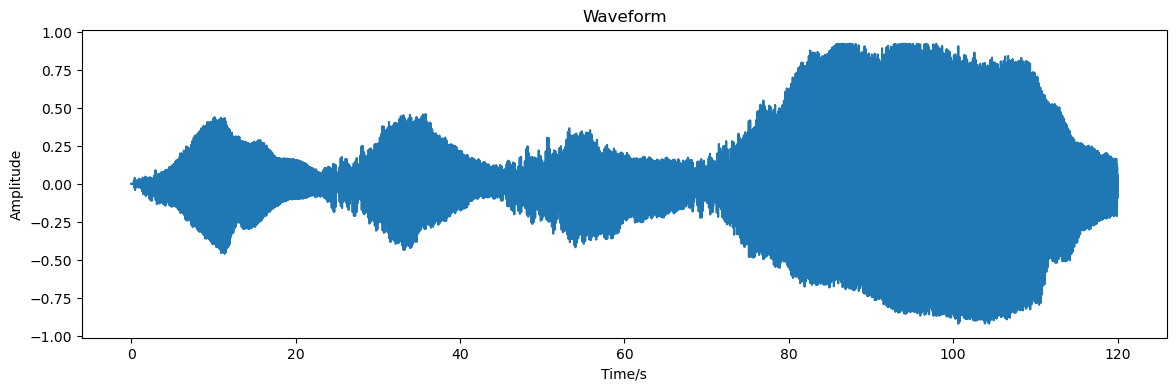

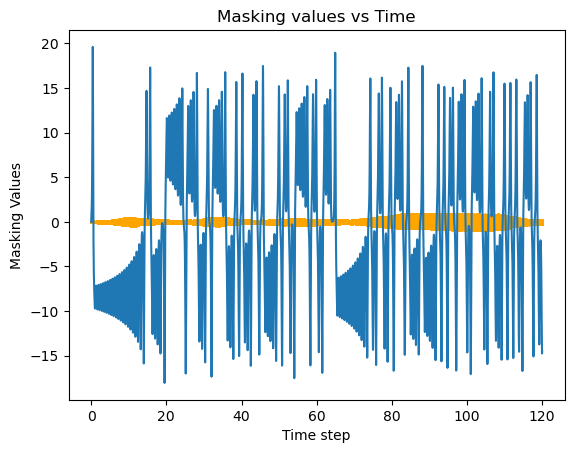

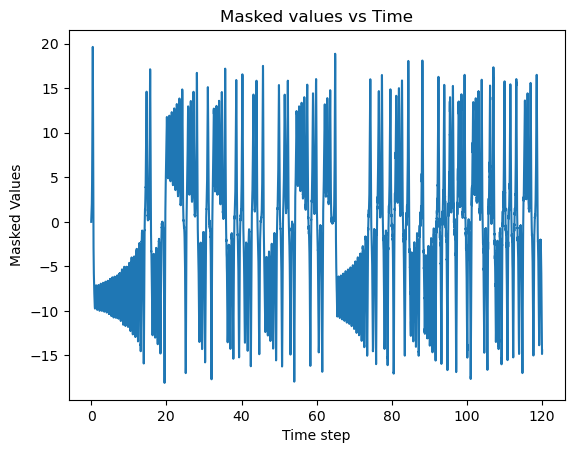

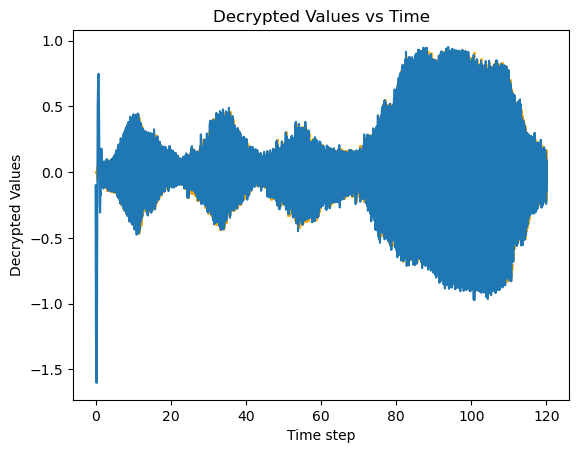

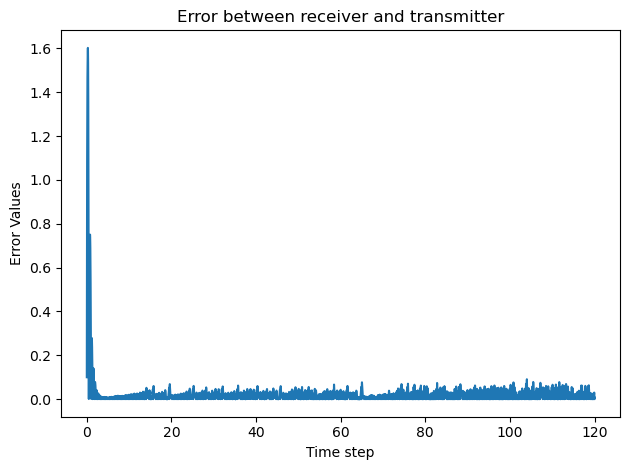

In [ ]:
# Processing a WAV file

from scipy.io.wavfile import read

# Read a WAV file
sample_rate, data = read("gameover.wav")

simulation_time = steps * dt
amplitude = 1/32767   # To normalise the amplitude
time = np.arange(len(data)) / sample_rate  # Time axis in seconds
time_scale = simulation_time / time[steps+1]
times = time_scale * time[:steps+1]
sound_waves = amplitude*data[:steps+1,0]   # Use only one of the stereo waveforms

plt.figure(figsize=(14, 4))
plt.plot(times, sound_waves)
plt.xlabel("Time/s")
plt.ylabel("Amplitude")
plt.title("Waveform")

masked_sound = x_values + sound_waves

# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_sound[i])

# Regenerating the mask to decrypt the signal
xs_values = state_receiver[:, 0]
decrypt_s = masked_sound - xs_values
error = np.abs(xs_values - x_values) # Error should decrease exponentially with time

# Calculate mean error in decryption
decrypt_error = np.mean(np.abs(decrypt_s - sound_waves))
print(decrypt_error)

# Plotting the chaotic mask and message signal
ax = plt.figure().add_subplot()
ax.plot(t, x_values)
ax.set_xlabel("Time step")
ax.set_ylabel("Masking Values")
ax.set_title('Masking values vs Time')
plt.scatter(times, sound_waves, c="orange", s=1)

# Plotting the masked signal
ax = plt.figure().add_subplot()
ax.plot(t, masked_sound)
ax.set_xlabel("Time step")
ax.set_ylabel("Masked Values")
ax.set_title('Masked values vs Time')

# Plotting the retrieved signal
ax = plt.figure().add_subplot()
ax.plot(t, decrypt_s)
ax.set_xlabel("Time step")
ax.set_ylabel("Decrypted Values")
ax.set_title('Decrypted Values vs Time')
plt.scatter(times, sound_waves, c="orange", s=1)

# Plotting the error
ax = plt.figure().add_subplot()
ax.plot(t, error)
ax.set_xlabel("Time step")
ax.set_ylabel("Error Values")
ax.set_title('Error between receiver and transmitter')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.io.wavfile import write

y1_int16 = (masked_sound * 32767).astype(np.int16)
y2_int16 = (decrypt_s * 32767).astype(np.int16)

write("encrypted.wav", sample_rate, y1_int16)
write("decrypted.wav", sample_rate, y2_int16)

# Image encryption Trial

## Method 1: Splitting the image's RGB values as RGBRGBRGB

C:\Users\User\AppData\Local\Temp\ipykernel_16344\3103930291.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(ar1.reshape(height,width,3),'RGB')


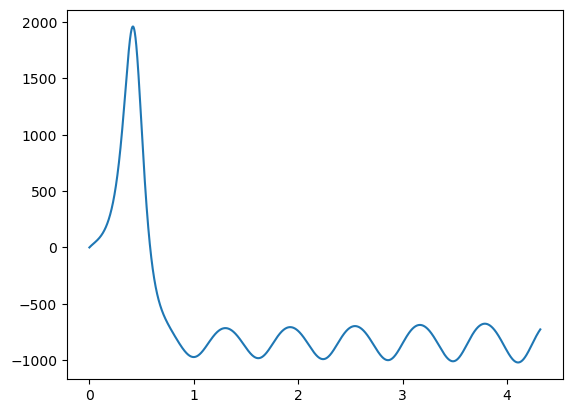

In [45]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

im=Image.open(r'C:\Undergraduate_NUS\Semester 1\SP2273\Lorenz encryption\SP2273_Group_project_Chaos_Sync\97-973734_instagram-clipart-picsart-png-instagram-logo-100x100-png.jpg')
def unwrapper(image):
    img_array=np.asarray(image)
    #flattening the array
    return img_array.flatten()

#Stringing everything together
#now the flattened array is basically (rgb_rgb_rgb.....rgb)*width*height
def wrapper(ar1,height,width):
    #my array has shape (height,width,3)
    return Image.fromarray(ar1.reshape(height,width,3),'RGB')
# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.0001
steps = im.size[1]*im.size[0]*3-1

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 1.0, 1.05)  # If the system synchronises, any initial values work

t = np.linspace(0, steps*dt, steps+1)   # time array

# Message signal sample
a = 1.0   # Modulate amplitude, if needed
k=100.0
#m = np.sin(60*t) + np.cos(40*t) + np.sin(20*np.pi*t) + np.cos(30*t)
m=unwrapper(im)

# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(k*y-x)
    dy_dt = r*x/k - y - x*z/k
    dz_dt = x*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(k*y-x) 
    dy_dt = r*input_signal/k - y - input_signal*z/k
    dz_dt = input_signal*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + m

#this masked_values are now sent over to the receiver. If they were intercepted and undone, this is the output:
masked_output=np.clip(np.floor(masked_values), 0, 255).astype(np.uint8)
image1=wrapper(masked_output,im.size[1],im.size[0])
image1.save("encrypted_image_1.jpeg", "jpeg")

# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])



# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]


decrypt = (masked_values - xr_values)*1
new_dec=np.clip(np.floor(decrypt), 0, 255).astype(np.uint8)
error = np.abs(xr_values - x_values) # Error should decrease exponentially with time
image=wrapper(new_dec,im.size[1],im.size[0])
image.save("decrypted_image_1.jpeg", "jpeg")
#GRAPHING initial message and decrypt
plt.plot(t,x_values)
#plt.plot(t,new_dec)

# Method 1A- adding transients(works well)

C:\Users\User\AppData\Local\Temp\ipykernel_18000\3979270790.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(ar1.reshape(height,width,3),'RGB')


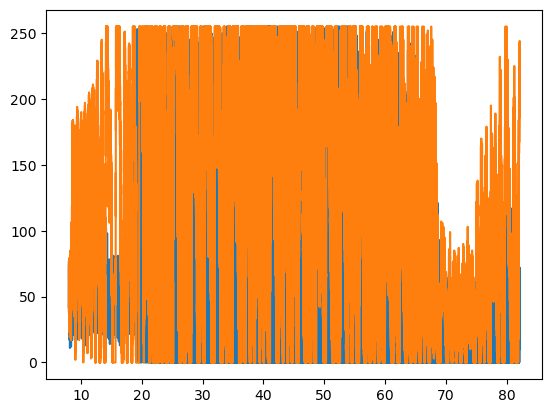

In [11]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
garbage=80000
im=Image.open(r'Screenshot 2025-10-31 115047.jpg')
def unwrapper(image):
    img_array=np.asarray(image)
    #flattening the array
    return img_array.flatten()

#Stringing everything together
#now the flattened array is basically (rgb_rgb_rgb.....rgb)*width*height
def wrapper(ar1,height,width):
    #my array has shape (height,width,3)
    return Image.fromarray(ar1.reshape(height,width,3),'RGB')
# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.0001
steps = im.size[1]*im.size[0]*3-1+garbage

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 1.0, 1.05)  # If the system synchronises, any initial values work

t = np.linspace(0, steps*dt, steps+1)   # time array

# Message signal sample
a = 1.0   # Modulate amplitude, if needed
k = 100.0 #mask scaling value
#m = np.sin(60*t) + np.cos(40*t) + np.sin(20*np.pi*t) + np.cos(30*t)
m1=unwrapper(im)
m = np.concatenate((np.zeros(garbage), m1))

# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(k*y-x)
    dy_dt = r*x/k - y - x*z/k
    dz_dt = x*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(k*y-x) 
    dy_dt = r*input_signal/k - y - input_signal*z/k
    dz_dt = input_signal*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + m

#this masked_values are now sent over to the receiver. If they were intercepted and undone, this is the output:
masked_output=np.clip(masked_values[garbage:], 0, 255).astype(np.uint8)
image1=wrapper(masked_output,im.size[1],im.size[0])
image1.save("encrypted_image.jpeg", "jpeg")

# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])



# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]


decrypt = (masked_values - xr_values)*1
new_dec=np.clip(decrypt[garbage:], 0, 255).astype(np.uint8)
error = np.abs(xr_values - x_values) # Error should decrease exponentially with time
image=wrapper(new_dec,im.size[1],im.size[0])
image.save("decrypted_image.jpeg", "jpeg")
#GRAPHING initial message and decrypt
plt.plot(t[garbage:],m1)
plt.plot(t[garbage:],new_dec)

# Method 2: Split the reds seperately, then the blues, then the greens (doesn't work as well)

(120, 120)
YASSS QUEEN
The root mean square error is:0.6271843302518899


C:\Users\User\AppData\Local\Temp\ipykernel_16344\3704698552.py:103: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image=Image.fromarray(image_signal,'RGB')
C:\Users\User\AppData\Local\Temp\ipykernel_16344\3704698552.py:105: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image1=Image.fromarray(wrapperv2(m1.astype(np.uint8),im.size[1],im.size[0]),'RGB')
C:\Users\User\AppData\Local\Temp\ipykernel_16344\3704698552.py:107: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image2=Image.fromarray(wrapperv2(np.clip(masked_values*a, 0, 255).astype(np.uint8),im.size[1],im.size[0]),'RGB')


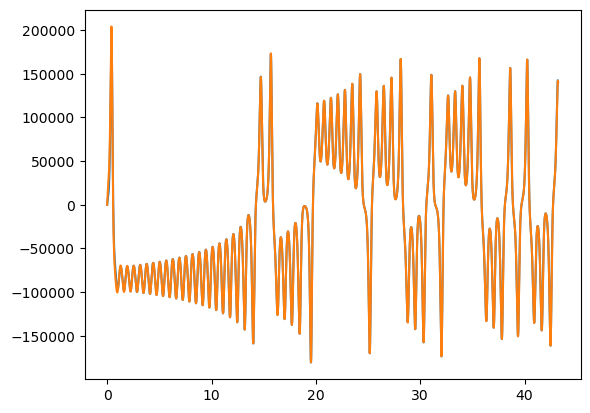

In [38]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt


im=Image.open(r'C:\Undergraduate_NUS\Semester 1\SP2273\Lorenz encryption\SP2273_Group_project_Chaos_Sync\97-973734_instagram-clipart-picsart-png-instagram-logo-100x100-png.jpg')
print(im.size)
def unwrapperv2(image=im):
    img_array=np.asarray(image)
    print('YASSS QUEEN')
    #composing the 3 different channels
    R=img_array[:,:,0]
    G=img_array[:,:,1]
    B=img_array[:,:,2]
    output=np.concatenate((R,G,B),axis= None)
    return output.flatten()

    

#Stringing everything together
#now the flattened array is basically (r_r_r_r_)*width*height+(g_g_g_g_)*width*height+(b_b_b_b_)*width*height
def wrapperv2(ar1,height,width):
    R=ar1[:height*width].reshape(height,width)
    G=ar1[height*width:2*height*width].reshape(height,width)
    B=ar1[2*height*width:].reshape(height,width)
    new_array=np.stack((R, G, B), axis=-1)

    #my array has shape (height,width,3)
    return new_array

#image=wrapperv2(unwrapperv2(),im.size[1],im.size[0])
#image.save("output_image_v3.jpg", "jpeg")

# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.001
steps = im.size[1]*im.size[0]*3-1

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 3.0, 0.05)  # If the system synchronises, any initial values work

t = np.linspace(0, steps*dt, steps+1)   # time array

# Message signal sample
a = 1.0 # Modulate amplitude, if needed
k = 10000.0 #k is x scale factor
'''m = np.sin(60*t) + np.cos(40*t) + np.sin(20*np.pi*t) + np.cos(30*t)'''
m1=unwrapperv2().astype(float)
m=m1/a

# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(k*y-x)
    dy_dt = r*x/k - y - x*z/k
    dz_dt = x*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(k*y-x) 
    dy_dt = r*input_signal/k - y - input_signal*z/k
    dz_dt = input_signal*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + m
# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])



# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]
decrypt = (masked_values - xr_values)

new_dec=np.clip(decrypt*a, 0, 255).astype(np.uint8)

error = np.abs(xr_values - x_values) # Error should decrease exponentially with time
image_signal=wrapperv2(new_dec,im.size[1],im.size[0])
image=Image.fromarray(image_signal,'RGB')
image.save("reconstructed_image11.jpg", "jpeg")
image1=Image.fromarray(wrapperv2(m1.astype(np.uint8),im.size[1],im.size[0]),'RGB')
image1.save("test.jpg", "jpeg")
image2=Image.fromarray(wrapperv2(np.clip(masked_values*a, 0, 255).astype(np.uint8),im.size[1],im.size[0]),'RGB')
image2.save("encrypted_image.jpg", "jpeg")
#metrics
RMSE=np.sqrt(np.sum((m-new_dec)**2))/m.size
print(f'The root mean square error is:{RMSE}')

#Graphing
#plt.plot(t,m)
#plt.plot(t,decrypt)
#plt.plot(t,masked_values)
plt.plot(t,x_values)
plt.plot(t,xr_values)

# 2A- giving the image signal some transients.(doesn't work as well)

(120, 120)
YASSS QUEEN


C:\Users\User\AppData\Local\Temp\ipykernel_16344\3423111212.py:104: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image=Image.fromarray(image_signal,'RGB')
C:\Users\User\AppData\Local\Temp\ipykernel_16344\3423111212.py:106: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image1=Image.fromarray(wrapperv2(m1.astype(np.uint8),im.size[1],im.size[0]),'RGB')
C:\Users\User\AppData\Local\Temp\ipykernel_16344\3423111212.py:108: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image2=Image.fromarray(wrapperv2(np.clip(masked_values[garbage:]*a, 0, 255).astype(np.uint8),im.size[1],im.size[0]),'RGB')


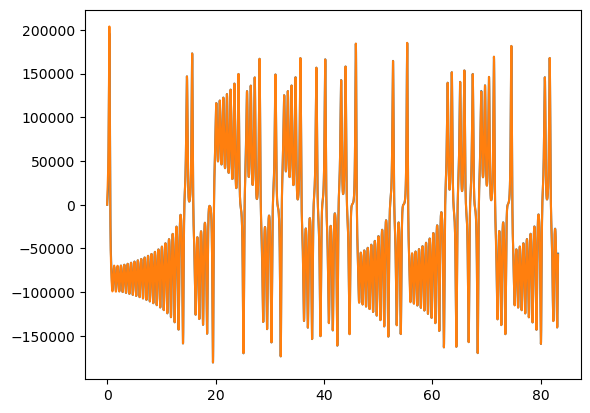

In [37]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

garbage=int(40000)
im=Image.open(r'C:\Undergraduate_NUS\Semester 1\SP2273\Lorenz encryption\SP2273_Group_project_Chaos_Sync\97-973734_instagram-clipart-picsart-png-instagram-logo-100x100-png.jpg')
print(im.size)
def unwrapperv2(image=im):
    img_array=np.asarray(image)
    print('YASSS QUEEN')
    #composing the 3 different channels
    R=img_array[:,:,0]
    G=img_array[:,:,1]
    B=img_array[:,:,2]
    output=np.concatenate((R,G,B),axis= None)
    return output.flatten()

    

#Stringing everything together
#now the flattened array is basically (r_r_r_r_)*width*height+(g_g_g_g_)*width*height+(b_b_b_b_)*width*height
def wrapperv2(ar1,height,width):
    R=ar1[:height*width].reshape(height,width)
    G=ar1[height*width:2*height*width].reshape(height,width)
    B=ar1[2*height*width:].reshape(height,width)
    new_array=np.stack((R, G, B), axis=-1)

    #my array has shape (height,width,3)
    return new_array

#image=wrapperv2(unwrapperv2(),im.size[1],im.size[0])
#image.save("output_image_v3.jpg", "jpeg")

# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.001
steps = im.size[1]*im.size[0]*3-1+garbage

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 3.0, 0.05)  # If the system synchronises, any initial values work

t = np.linspace(0, steps*dt, steps+1)   # time array

# Message signal sample
a = 1.0 # Modulate amplitude, if needed
k = 10000.0 #k is x scale factor
'''m = np.sin(60*t) + np.cos(40*t) + np.sin(20*np.pi*t) + np.cos(30*t)'''
m1=unwrapperv2().astype(float)
m = np.concatenate((np.zeros(garbage), m1/a))


# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(k*y-x)
    dy_dt = r*x/k - y - x*z/k
    dz_dt = x*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(k*y-x) 
    dy_dt = r*input_signal/k - y - input_signal*z/k
    dz_dt = input_signal*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + m
# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])



# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]
decrypt = (masked_values - xr_values)

new_dec=np.clip(a*decrypt[garbage:], 0, 255).astype(np.uint8)

error = np.abs(xr_values - x_values) # Error should decrease exponentially with time
image_signal=wrapperv2(new_dec,im.size[1],im.size[0])
image=Image.fromarray(image_signal,'RGB')
image.save("reconstructed_image.jpg", "jpeg")
image1=Image.fromarray(wrapperv2(m1.astype(np.uint8),im.size[1],im.size[0]),'RGB')
image1.save("test.jpg", "jpeg")
image2=Image.fromarray(wrapperv2(np.clip(masked_values[garbage:]*a, 0, 255).astype(np.uint8),im.size[1],im.size[0]),'RGB')
image2.save("encrypted_image.jpg", "jpeg")
#metrics
#RMSE=np.sqrt(np.sum((m-new_dec)**2))/m.size
#print(f'The root mean square error is:{RMSE}')

#Graphing
#plt.plot(t,m)
#plt.plot(t,decrypt)
#plt.plot(t,masked_values)
plt.plot(t,x_values)
plt.plot(t,xr_values)